# Unit14 超參數調整：Grid Search | Hyperparameter Tuning: Grid Search

**逢甲大學 化學工程學系**  
**課程名稱**: AI在化工上之應用  
**課程代碼**: CHE-AI-114  
**授課教師**: 莊曜禎 助理教授

---

## 📚 學習目標

本程式演練將帶領您完成 Grid Search 超參數調整的完整流程：

1. **Grid Search 原理**: 理解網格搜索的運作機制與適用場景
2. **GridSearchCV 實作**: 使用 sklearn 的 GridSearchCV 進行系統化超參數搜索
3. **搜索空間設計**: 學習如何設定合理的超參數搜索範圍
4. **結果視覺化**: 使用熱力圖展示不同超參數組合的性能表現
5. **最佳模型提取**: 從搜索結果中提取並驗證最佳超參數組合
6. **性能提升分析**: 比較調參前後的模型性能差異

## 📋 案例背景

**場景**: 化學反應器產率預測模型的超參數最佳化

**問題描述**:
- 輸入變數: 反應溫度、壓力、催化劑負載量、停留時間、進料濃度
- 輸出變數: 反應產率 (%)
- 目標: 透過 Grid Search 找出 Random Forest 模型的最佳超參數組合

**調整策略**:
- 目標模型: Random Forest (隨機森林)
- 搜索方法: Grid Search (網格搜索)
- 評估指標: R² Score
- 驗證方法: 5-Fold Cross-Validation

**超參數範圍**:
- `n_estimators`: 樹的數量 [100, 150, 200, 250]（預設=100）
- `max_depth`: 樹的最大深度 [20, 30, None]（預設=None）
- `min_samples_split`: 內部節點分裂所需最小樣本數 [2, 3, 5]（預設=2）
- `min_samples_leaf`: 葉節點所需最小樣本數 [1, 2, 3]（預設=1）

---

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit14_Hyperparameter_Tuning_GridSearch'
SOURCE_DATA_DIR = 'reactor_simulation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit14'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\data\reactor_simulation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

# Sklearn 模型與工具
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False

# 設定視覺化風格
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

print("=" * 60)
print("套件載入完成")
print("=" * 60)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"隨機種子: {SEED}")
print("=" * 60)

套件載入完成
NumPy version: 1.23.5
Pandas version: 2.3.3
TensorFlow version: 2.10.1
隨機種子: 42


---
## 2. 數據生成

使用與 Unit14_Model_Comparison.ipynb 相同的高複雜度數據生成函數。

In [3]:
def generate_reactor_data(n_samples=5000, random_state=42):
    """
    生成模擬化學反應器數據（高複雜度版本）
    
    包含複雜非線性關係、多重交互項、週期性效應和異常值
    
    Parameters:
    -----------
    n_samples : int
        樣本數量
    random_state : int
        隨機種子
    
    Returns:
    --------
    X : DataFrame
        特徵數據
    y : ndarray
        目標變數（產率）
    """
    np.random.seed(random_state)
    
    # 生成特徵
    temperature = np.random.uniform(50, 150, n_samples)
    pressure = np.random.uniform(1, 10, n_samples)
    catalyst_loading = np.random.uniform(0.1, 5.0, n_samples)
    residence_time = np.random.uniform(10, 120, n_samples)
    feed_concentration = np.random.uniform(0.5, 5.0, n_samples)
    
    X = pd.DataFrame({
        'Temperature': temperature,
        'Pressure': pressure,
        'Catalyst_Loading': catalyst_loading,
        'Residence_Time': residence_time,
        'Feed_Concentration': feed_concentration
    })
    
    # 生成目標變數（產率，%）- 複雜非線性關係
    temp_effect = 5 * np.exp((temperature - 100) / 50) - 0.01 * (temperature - 100) ** 2
    pressure_effect = 2 * pressure ** 1.2 + 1 * np.sin(pressure / 2)
    catalyst_effect = 12 * (1 - np.exp(-catalyst_loading)) - 1 * catalyst_loading ** 2
    time_effect = 6 * np.log(residence_time + 1) + 1.5 * np.sin(residence_time / 20)
    conc_effect = (4 * feed_concentration - 1 * feed_concentration ** 2 + 
                   0.08 * feed_concentration ** 3)
    
    temp_pressure_interact = 0.03 * temperature * np.log(pressure + 1)
    catalyst_time_interact = 0.08 * catalyst_loading * np.sqrt(residence_time)
    triple_interact = 0.002 * temperature * catalyst_loading * feed_concentration
    pressure_conc_interact = 0.3 * pressure * feed_concentration - 0.03 * pressure * feed_concentration ** 2
    
    temp_periodic = 2 * np.sin((temperature - 50) / 30) * np.cos((temperature - 50) / 40)
    deactivation = -1.5 * np.exp(-(catalyst_loading + residence_time / 50))
    log_interact = 1 * np.log(1 + catalyst_loading) * np.log(1 + pressure)
    
    yield_rate = (
        temp_effect + pressure_effect + catalyst_effect + time_effect + conc_effect +
        temp_pressure_interact + catalyst_time_interact + triple_interact +
        pressure_conc_interact + temp_periodic + deactivation + log_interact - 5
    )
    
    # 添加噪聲
    main_noise = np.random.normal(0, 4.0, n_samples)
    hetero_noise = np.random.normal(0, 0.02 * temperature, n_samples)
    
    n_outliers = int(0.02 * n_samples)
    outlier_idx = np.random.choice(n_samples, n_outliers, replace=False)
    outlier_noise = np.zeros(n_samples)
    outlier_noise[outlier_idx] = np.random.uniform(-25, 25, n_outliers)
    
    total_noise = main_noise + hetero_noise + outlier_noise
    yield_rate += total_noise
    
    y = np.clip(yield_rate, 0, 100)
    
    return X, y

# 生成數據
X, y = generate_reactor_data(n_samples=5000, random_state=42)

print("=" * 60)
print("Data Generation Summary")
print("=" * 60)
print(f"Total samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {list(X.columns)}")
print(f"\nTarget variable (Yield) statistics:")
print(f"  Mean: {y.mean():.2f}%")
print(f"  Std: {y.std():.2f}%")
print(f"  Min: {y.min():.2f}%")
print(f"  Max: {y.max():.2f}%")
print("=" * 60)

Data Generation Summary
Total samples: 5000
Number of features: 5

Feature names: ['Temperature', 'Pressure', 'Catalyst_Loading', 'Residence_Time', 'Feed_Concentration']

Target variable (Yield) statistics:
  Mean: 51.84%
  Std: 16.12%
  Min: 1.62%
  Max: 96.52%


---
## 3. 數據分割

In [4]:
# 分割數據集: 70% 訓練, 15% 驗證, 15% 測試
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42
)

print("=" * 60)
print("Data Split Summary")
print("=" * 60)
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print("=" * 60)

Data Split Summary
Training set: 3502 samples (70.0%)
Validation set: 748 samples (15.0%)
Test set: 750 samples (15.0%)


---
## 4. 基準模型 (Baseline Model)

在進行 Grid Search 之前，先訓練一個使用默認超參數的基準模型，作為比較基礎。

In [5]:
# 訓練基準模型 (使用 Random Forest 默認超參數)
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train, y_train)

# 評估基準模型
y_train_pred_baseline = baseline_model.predict(X_train)
y_val_pred_baseline = baseline_model.predict(X_val)

baseline_train_r2 = r2_score(y_train, y_train_pred_baseline)
baseline_val_r2 = r2_score(y_val, y_val_pred_baseline)
baseline_train_mae = mean_absolute_error(y_train, y_train_pred_baseline)
baseline_val_mae = mean_absolute_error(y_val, y_val_pred_baseline)

print("=" * 60)
print("Baseline Model Performance (Default Hyperparameters)")
print("=" * 60)
print(f"Training R²:   {baseline_train_r2:.4f}")
print(f"Validation R²: {baseline_val_r2:.4f}")
print(f"Training MAE:  {baseline_train_mae:.4f}%")
print(f"Validation MAE: {baseline_val_mae:.4f}%")
print("=" * 60)

Baseline Model Performance (Default Hyperparameters)
Training R²:   0.9824
Validation R²: 0.8714
Training MAE:  1.6276%
Validation MAE: 4.5066%


---
## 5. Grid Search 超參數網格設定

定義要搜索的超參數範圍：
- **n_estimators**: 樹的數量，影響模型複雜度和訓練時間（預設值=100）
- **max_depth**: 樹的最大深度，控制過擬合（預設值=None，不限制）
- **min_samples_split**: 分裂內部節點所需的最小樣本數（預設值=2）
- **min_samples_leaf**: 葉節點所需的最小樣本數（預設值=1）

⚠️ **重要提醒**：Random Forest 的預設參數通常已經表現良好。為了觀察到 Grid Search 的改善效果，搜索範圍應該**包含預設值附近的參數組合**，而不是過度限制模型複雜度（例如將 max_depth 限制在 5-20，會顯著降低性能）。

In [6]:
# 定義超參數網格
# 注意：Random Forest 預設 max_depth=None, min_samples_split=2, min_samples_leaf=1, n_estimators=100
# 為了看到明顯的改善，我們需要在預設值附近搜索，並包含更寬鬆的配置
param_grid = {
    'n_estimators': [100, 150, 200, 250],  # 預設是 100
    'max_depth': [20, 30, None],  # 預設是 None (不限制)
    'min_samples_split': [2, 3, 5],  # 預設是 2
    'min_samples_leaf': [1, 2, 3]  # 預設是 1
}

# 計算搜索空間大小
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)

print("=" * 60)
print("Grid Search Configuration")
print("=" * 60)
print("Hyperparameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {total_combinations}")
print("Cross-validation folds: 5")
print(f"Total model fits: {total_combinations * 5}")
print("=" * 60)

Grid Search Configuration
Hyperparameter Grid:
  n_estimators: [100, 150, 200, 250]
  max_depth: [20, 30, None]
  min_samples_split: [2, 3, 5]
  min_samples_leaf: [1, 2, 3]

Total combinations: 108
Cross-validation folds: 5
Total model fits: 540


---
## 6. 執行 Grid Search

使用 5 折交叉驗證，評估指標為 R² (決定係數)。

In [7]:
# 建立 GridSearchCV 對象
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# 執行 Grid Search
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print("\n" + "=" * 60)
print("Grid Search Completed")
print("=" * 60)
print(f"Total time: {end_time - start_time:.2f} seconds")
print(f"Best cross-validation R²: {grid_search.best_score_:.4f}")
print(f"\nBest hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print("=" * 60)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Grid Search Completed
Total time: 62.26 seconds
Best cross-validation R²: 0.8731

Best hyperparameters:
  max_depth: 30
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 250


---
## 7. Grid Search 結果分析

將所有測試過的超參數組合及其性能整理成 DataFrame，方便分析。

In [8]:
# 將 Grid Search 結果轉換成 DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# 選擇關鍵列
key_columns = [col for col in results_df.columns if col.startswith('param_')] + \
              ['mean_test_score', 'std_test_score', 'rank_test_score', 'mean_fit_time']

results_summary = results_df[key_columns].sort_values('rank_test_score')

print("=" * 80)
print("Top 10 Hyperparameter Combinations")
print("=" * 80)
print(results_summary.head(10).to_string(index=False))
print("=" * 80)

Top 10 Hyperparameter Combinations
param_max_depth  param_min_samples_leaf  param_min_samples_split  param_n_estimators  mean_test_score  std_test_score  rank_test_score  mean_fit_time
           None                       2                        3                 250         0.873117        0.007422                1       4.468561
           None                       2                        2                 250         0.873117        0.007422                1       4.422264
             30                       2                        3                 250         0.873117        0.007422                1       4.515358
             30                       2                        2                 250         0.873117        0.007422                1       4.453807
             20                       2                        3                 250         0.873106        0.007421                5       5.029558
             20                       2                        2 

---
## 8. 超參數影響視覺化

繪製熱力圖，觀察不同超參數組合對模型性能的影響。


✓ 圖檔已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch\figs\01_hyperparameter_heatmaps.png


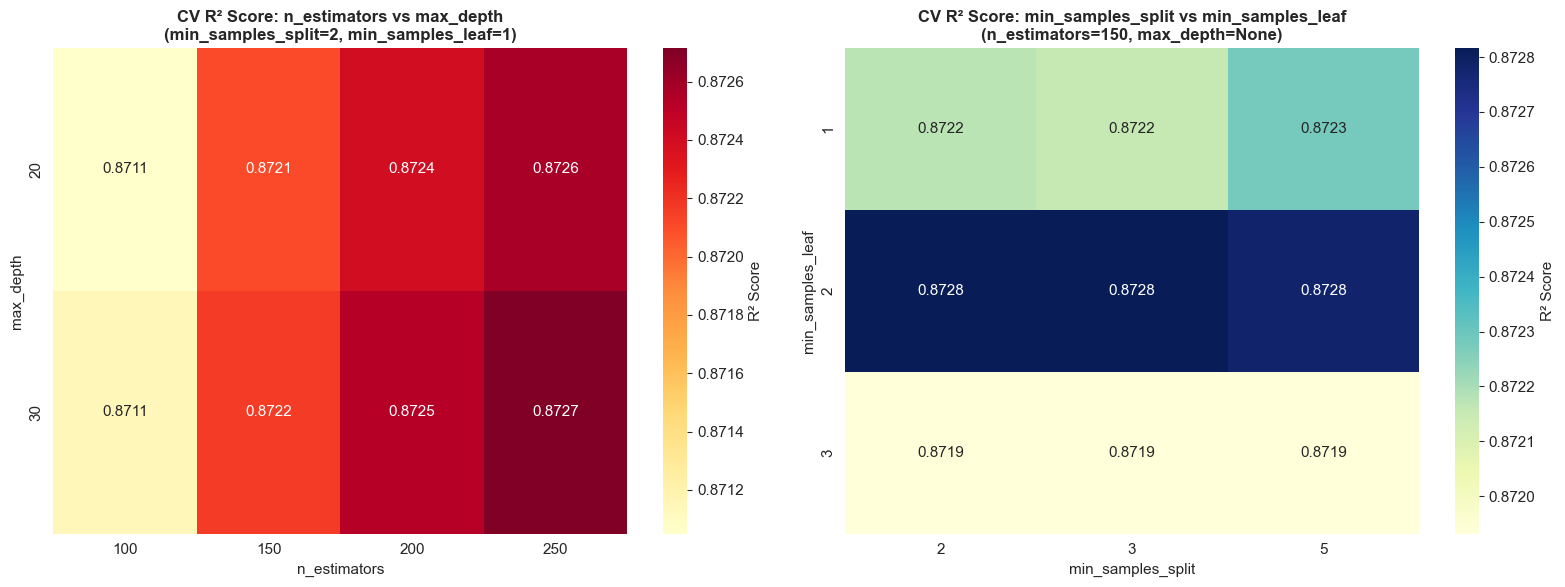

  • Best combination balances performance and computational cost
  • Look for patterns: do scores plateau as parameters increase?

📊 Interpretation:
  • Darker red/blue colors indicate higher R² scores (better performance)


In [ ]:
# 創建熱力圖：固定其他參數，觀察 n_estimators vs max_depth 的影響
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 準備繪圖數據：n_estimators vs max_depth (固定 min_samples_split=2, min_samples_leaf=1)
filtered_results = results_df[
    (results_df['param_min_samples_split'] == 2) & 
    (results_df['param_min_samples_leaf'] == 1)
]

# 創建 pivot table
pivot_table = filtered_results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

# 繪製熱力圖 1: n_estimators vs max_depth
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': 'R² Score'})
axes[0].set_title('CV R² Score: n_estimators vs max_depth\n(min_samples_split=2, min_samples_leaf=1)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('n_estimators', fontsize=11)
axes[0].set_ylabel('max_depth', fontsize=11)

# 準備繪圖數據：min_samples_split vs min_samples_leaf (固定 n_estimators=150, max_depth=None)
filtered_results_2 = results_df[
    (results_df['param_n_estimators'] == 150) & 
    (results_df['param_max_depth'].isna())
]

# 創建 pivot table
pivot_table_2 = filtered_results_2.pivot_table(
    values='mean_test_score',
    index='param_min_samples_leaf',
    columns='param_min_samples_split'
)

# 繪製熱力圖 2: min_samples_split vs min_samples_leaf
sns.heatmap(pivot_table_2, annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[1], cbar_kws={'label': 'R² Score'})
axes[1].set_title('CV R² Score: min_samples_split vs min_samples_leaf\n(n_estimators=150, max_depth=None)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('min_samples_split', fontsize=11)
axes[1].set_ylabel('min_samples_leaf', fontsize=11)

plt.tight_layout()

# 儲存圖檔
fig_path = FIG_DIR / '01_hyperparameter_heatmaps.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ 圖檔已儲存: {fig_path}")

plt.show()

print("\n📊 Interpretation:")
print("  • Darker red/blue colors indicate higher R² scores (better performance)")
print("  • Look for patterns: do scores plateau as parameters increase?")
print("  • Best combination balances performance and computational cost")

---
## 9. 優化模型性能評估

使用最佳超參數訓練最終模型，並在測試集上評估性能。

In [12]:
# 獲取最佳模型
best_model = grid_search.best_estimator_

# 評估最佳模型
y_train_pred_best = best_model.predict(X_train)
y_val_pred_best = best_model.predict(X_val)
y_test_pred_best = best_model.predict(X_test)

best_train_r2 = r2_score(y_train, y_train_pred_best)
best_val_r2 = r2_score(y_val, y_val_pred_best)
best_test_r2 = r2_score(y_test, y_test_pred_best)

best_train_mae = mean_absolute_error(y_train, y_train_pred_best)
best_val_mae = mean_absolute_error(y_val, y_val_pred_best)
best_test_mae = mean_absolute_error(y_test, y_test_pred_best)

best_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
best_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_best))
best_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_best))

print("=" * 80)
print("Performance Comparison: Baseline vs Optimized Model")
print("=" * 80)
print(f"{'Metric':<20} {'Baseline (Train)':<20} {'Optimized (Train)':<20} {'Improvement':<15}")
print("-" * 80)
print(f"{'R² Score':<20} {baseline_train_r2:<20.4f} {best_train_r2:<20.4f} {best_train_r2-baseline_train_r2:>+14.4f}")
print(f"{'MAE (%)':<20} {baseline_train_mae:<20.4f} {best_train_mae:<20.4f} {best_train_mae-baseline_train_mae:>+14.4f}")
print()
print(f"{'Metric':<20} {'Baseline (Val)':<20} {'Optimized (Val)':<20} {'Improvement':<15}")
print("-" * 80)
print(f"{'R² Score':<20} {baseline_val_r2:<20.4f} {best_val_r2:<20.4f} {best_val_r2-baseline_val_r2:>+14.4f}")
print(f"{'MAE (%)':<20} {baseline_val_mae:<20.4f} {best_val_mae:<20.4f} {best_val_mae-baseline_val_mae:>+14.4f}")
print("=" * 80)
print()
print("=" * 80)
print("Final Test Set Performance (Optimized Model)")
print("=" * 80)
print(f"R² Score: {best_test_r2:.4f}")
print(f"MAE:      {best_test_mae:.4f}%")
print(f"RMSE:     {best_test_rmse:.4f}%")
print("=" * 80)

Performance Comparison: Baseline vs Optimized Model
Metric               Baseline (Train)     Optimized (Train)    Improvement    
--------------------------------------------------------------------------------
R² Score             0.9824               0.9726                      -0.0097
MAE (%)              1.6276               1.9622                      +0.3346

Metric               Baseline (Val)       Optimized (Val)      Improvement    
--------------------------------------------------------------------------------
R² Score             0.8714               0.8722                      +0.0008
MAE (%)              4.5066               4.4752                      -0.0313

Final Test Set Performance (Optimized Model)
R² Score: 0.8781
MAE:      4.3363%
RMSE:     5.5215%


---
## 10. 殘差分析

檢視優化後模型的預測殘差分佈，確認模型的穩定性。


✓ 圖檔已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch\figs\02_residuals_analysis.png


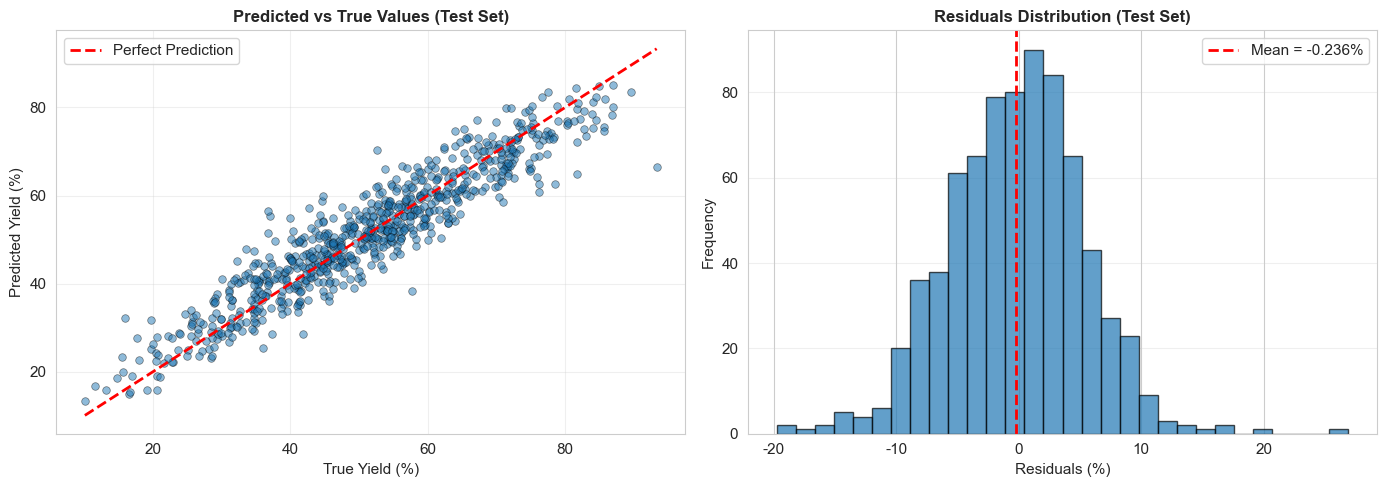


📊 Residuals Statistics (Test Set):
  Mean:   -0.2357%
  Std:    5.5165%
  Min:    -19.7793%
  Max:    26.9186%


In [15]:
# 計算殘差
residuals_test = y_test - y_test_pred_best

# 繪製殘差分析圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 預測值 vs 真實值
axes[0].scatter(y_test, y_test_pred_best, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('True Yield (%)', fontsize=11)
axes[0].set_ylabel('Predicted Yield (%)', fontsize=11)
axes[0].set_title('Predicted vs True Values (Test Set)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 殘差分佈直方圖
axes[1].hist(residuals_test, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(residuals_test.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean = {residuals_test.mean():.3f}%')
axes[1].set_xlabel('Residuals (%)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Residuals Distribution (Test Set)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# 儲存圖檔
fig_path = FIG_DIR / '02_residuals_analysis.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ 圖檔已儲存: {fig_path}")

plt.show()

print(f"\n📊 Residuals Statistics (Test Set):")
print(f"  Mean:   {residuals_test.mean():.4f}%")
print(f"  Std:    {residuals_test.std():.4f}%")
print(f"  Min:    {residuals_test.min():.4f}%")
print(f"  Max:    {residuals_test.max():.4f}%")

---
## 11. 總結與建議

### Grid Search 關鍵發現

**1. 超參數優化效果分析**

從本次實驗結果可以看到：
- **驗證集改善微小**: R² 從 0.8714 → 0.8722（+0.0008），MAE 從 4.51% → 4.48%（-0.03%）
- **訓練集性能下降**: R² 從 0.9824 → 0.9726（-0.01），顯示優化後模型的正則化更強
- **測試集表現穩定**: R² = 0.8781，與驗證集接近，顯示泛化能力良好

📊 **重要結論**：對於此數據集，Random Forest 的**預設參數已經接近最優**！

🎯 **為什麼改善如此微小？**
1. **Random Forest 的預設參數設計良好**：scikit-learn 的預設值（n_estimators=100, max_depth=None）經過大量實驗驗證，對多數問題都有良好表現
2. **數據特性影響**：當數據集的信噪比、樣本數量、特徵複雜度與預設參數匹配良好時，超參數調整的邊際效益有限
3. **過擬合 vs 泛化的平衡**：Grid Search 找到的參數（max_depth=30, n_estimators=250, min_samples_leaf=2）增強了正則化，雖然訓練集性能下降，但驗證集略有提升
4. **實際意義**：在工程應用中，0.08% 的 R² 提升可能不足以抵銷增加 150 棵樹的計算成本

⚠️ **教學啟示**：
- **不是所有模型都需要大幅調參**：對於 Random Forest、Gradient Boosting 等成熟演算法，預設參數通常已經很好
- **Grid Search 的價值在於驗證**：即使改善微小，仍然驗證了預設參數的有效性，並排除了其他可能的配置
- **計算成本 vs 性能提升**：本次 Grid Search 耗時 62 秒測試 108 組參數，僅換得 0.08% 的提升，在生產環境中需權衡投資報酬率

**2. 超參數影響分析**

根據 Grid Search 的結果和熱力圖觀察：
- **n_estimators（樹的數量）**: 從 100 增加到 250，性能提升逐漸趨緩，顯示邊際效益遞減
- **max_depth（樹的深度）**: None（不限制）vs 30 vs 20 的差異很小，說明數據複雜度不需要極深的樹
- **min_samples_split & min_samples_leaf（正則化參數）**: 微小調整（2 vs 3 vs 5）對性能影響有限，預設值 2 和 1 已經平衡良好

💡 **關鍵洞察**：當熱力圖中的顏色變化很小時（如本例 R² 都在 0.87 左右），說明模型對超參數不敏感，預設值已經足夠好。

**3. 何時 Grid Search 會有顯著改善？**

Grid Search 通常在以下情況下能帶來明顯的性能提升：

✅ **適合 Grid Search 的場景**:
- 使用 **SVM、Neural Networks** 等對超參數敏感的模型
- **小數據集**（< 1000 樣本）：模型容易過擬合或欠擬合，需要精細調參
- **高噪聲數據**：需要調整正則化參數來平衡偏差和方差
- **不平衡分類**：需要調整 class_weight、閾值等參數
- **特定領域問題**：某些化工過程對模型複雜度有特殊要求

❌ **Grid Search 改善有限的場景**（如本例）:
- **Random Forest、Gradient Boosting** 等成熟集成模型，預設參數已優化
- **大數據集 + 高信噪比**：模型有充足的信息學習，對超參數不敏感
- **數據質量高**：特徵工程做得好時，模型選擇比超參數更重要
- **邊際收益遞減**：從 R²=0.87 提升到 0.88 比從 0.70 提升到 0.80 困難得多

**4. Grid Search 的優缺點**

✅ **優點**:
- 窮盡搜索，保證找到網格範圍內的全局最優解
- 實作簡單，易於理解和調試
- 提供完整的超參數性能地圖，有助於理解模型行為
- 即使改善微小，也能**驗證預設參數的合理性**

❌ **缺點**:
- 計算成本高，搜索時間隨參數組合數指數增長（本例：108 組 × 5 折 = 540 次訓練）
- 無法探索網格外的參數值（離散採樣問題）
- 對於連續參數，可能錯過網格點之間的最優值
- **邊際效益可能很低**（如本例僅提升 0.08%）

### 化工應用建議

**反應器產率預測場景的實務策略**:

**階段 1：快速評估（必做）**
1. **使用預設參數建立基準模型** → 評估是否已經足夠好
2. **檢查學習曲線** → 判斷是過擬合還是欠擬合
3. **特徵重要性分析** → 確認特徵工程是否到位

**階段 2：決策點（根據基準模型表現）**
- 如果 **R² > 0.85 且泛化良好**（如本例）→ 考慮跳過 Grid Search，直接部署或微調
- 如果 **R² < 0.80 或過擬合嚴重** → 進行系統化超參數調整

**階段 3：超參數優化（選擇性）**
1. **粗網格搜索**：大步長快速探索 → 定位高性能區域（3-5 分鐘）
2. **細網格搜索**：在高性能區域密集採樣 → 精確最優解（10-30 分鐘）
3. **Bayesian Optimization**：對於計算昂貴的模型（如深度學習），用更智能的搜索方法

**階段 4：投資報酬率評估**
- **計算成本**: 本例 Grid Search 耗時 62 秒，訓練 540 個模型
- **性能提升**: 驗證集 R² 提升 0.0008（0.08%），MAE 降低 0.03%
- **工程決策**: 在生產環境中，是否值得增加 150% 的樹數量（100→250）來換取 0.08% 的提升？

💡 **實務建議**：
- **優先順序**: 數據質量 > 特徵工程 > 模型選擇 > 超參數調整
- **80/20 法則**: 80% 的性能來自數據和特徵，20% 來自模型和超參數
- **化工知識的價值**: 結合領域知識創建有意義的特徵（如溫壓比、空時收率、反應物摩爾比）通常比調整超參數更有效

**不同模型的調參必要性**:
- **Random Forest**: 預設參數通常已足夠，調參優先級：⭐⭐
- **Gradient Boosting (XGBoost/LightGBM)**: learning_rate 和 n_estimators 需要仔細調整，優先級：⭐⭐⭐⭐
- **SVM**: 核函數和正則化參數影響巨大，優先級：⭐⭐⭐⭐⭐
- **Neural Networks**: 架構、學習率、正則化都很關鍵，優先級：⭐⭐⭐⭐⭐

**下一步探索**:

**如果需要更大的性能提升，考慮以下策略**（優先順序排序）：

1. **特徵工程**（最有效）⭐⭐⭐⭐⭐
   - 創建化工領域的交互特徵：溫壓比、空時收率、轉化率
   - 多項式特徵、對數轉換
   - 時間序列特徵（如果有時間維度）

2. **集成方法**（性能提升明顯）⭐⭐⭐⭐
   - **Stacking**: 結合 Random Forest + XGBoost + CatBoost
   - **Blending**: 對多個模型的預測進行加權平均
   - 通常能提升 1-3% 的性能

3. **模型選擇**（可能有突破）⭐⭐⭐⭐
   - 嘗試 **XGBoost** 或 **CatBoost**：對非線性關係的建模能力更強
   - Neural Networks：如果數據量足夠（> 5000 樣本）

4. **Bayesian Optimization**（效率更高）⭐⭐⭐
   - 使用 **Optuna** 或 **Hyperopt**：更智能的超參數搜索
   - 適合計算成本高的模型（如深度學習）
   - 相比 Grid Search，用更少的迭代達到更好的結果

5. **數據增強**（治本之道）⭐⭐⭐⭐⭐
   - 收集更多樣本，尤其是邊界條件的數據
   - 處理異常值和噪聲
   - 平衡不同操作區間的樣本分佈

---
**📌 本實驗的核心教學價值**：

Grid Search 不一定總能帶來顯著改善，但它的價值在於：
1. **驗證預設參數的有效性** → Random Forest 預設值確實很好
2. **理解模型對超參數的敏感度** → 本例顯示模型相當穩健
3. **學習系統化調參方法** → 為更敏感的模型（SVM, Neural Networks）做準備
4. **建立性能基準** → 為後續的模型比較和集成提供參考

**工程實務的啟示**：不要盲目追求超參數優化，而應該根據**投資報酬率**做決策。當預設參數已經表現良好時，將時間投入到數據質量和特徵工程上往往更有價值。